## Import Libraries

In [1]:
#Importing the required packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

## Import Dataset

In [2]:
df=pd.read_csv('houses_to_rent.csv')
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


In [3]:
df.shape

(10692, 13)

In [5]:
df.isnull().sum()

city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

In [6]:
df.dtypes

city                   object
area                    int64
rooms                   int64
bathroom                int64
parking spaces          int64
floor                  object
animal                 object
furniture              object
hoa (R$)                int64
rent amount (R$)        int64
property tax (R$)       int64
fire insurance (R$)     int64
total (R$)              int64
dtype: object

**Inicial observations:**
*     There are 13 features and 10692 instances
*     There are no NaN Values
*     Most columns are numerical
*     Most houses accept animals
*     Most houses are not furnished
*     São Paulo is the city with more houses
*     There are potencial outliers

## Cleansing the Data

**We can see that floor type is 'object', so let's check why**

In [7]:
df['floor'].unique()

array(['7', '20', '6', '2', '1', '-', '4', '3', '10', '11', '24', '9',
       '8', '17', '18', '5', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '51',
       '32'], dtype=object)

**We can see that are '-' values, so we got to clean that**

In [8]:
df.loc[df['floor'] == '-', 'floor'] = 0
df['floor'] = df['floor'].astype('int64')

## Checking for Outliers

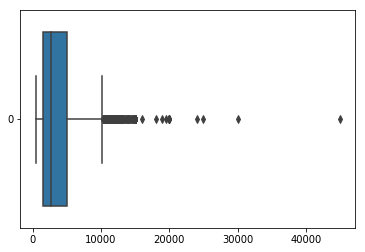

In [9]:
sns.boxplot(data = df['rent amount (R$)'], orient='horizontal')

**We can see that are some outliers, so we got treat them**

## Dealing with Outliers

In [10]:
# First let make a copy of our dataset so we can separate them.
data = df.copy()

**To treat the outliers we will use the interquartile range and we will perform this analysis in every city**

In [11]:
city_group = data.groupby('city')['rent amount (R$)']

Q1 = city_group.quantile(.25)
Q3 = city_group.quantile(.75)

# IQR = Interquartile Range
IQR = Q3 - Q1

# Limits
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# DataFrame to store the new data
new_data = pd.DataFrame()

for city in city_group.groups.keys():
    is_city = data['city'] == city
    accepted_limit = ((data['rent amount (R$)'] >= lower[city]) &
                     (data['rent amount (R$)'] <= upper[city]))
    
    select = is_city & accepted_limit
    data_select = data[select]
    new_data = pd.concat([new_data, data_select])
    
data = new_data.copy()

In [12]:
# New dataset
data.describe()

,area,rooms,bathroom,parking spaces,floor,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9.974000e+03,9974.000000,9974.000000,9974.000000,9.974000e+03
mean,134.483958,2.413575,2.101364,1.479848,5.071185,1.101394e+03,3300.496691,315.949469,44.834369,4.762867e+03
std,550.700299,1.120755,1.300777,1.482660,6.051531,1.601059e+04,2497.261703,3198.118033,34.438465,1.665255e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,55.000000,2.000000,1.000000,0.000000,1.000000,1.900000e+02,1500.000000,34.000000,20.000000,1.990000e+03
50%,85.000000,2.000000,2.000000,1.000000,3.000000,5.500000e+02,2500.000000,110.000000,33.000000,3.327000e+03
75%,160.000000,3.000000,3.000000,2.000000,8.000000,1.133000e+03,4233.750000,315.000000,58.000000,5.855250e+03
max,46335.000000,10.000000,10.000000,12.000000,301.000000,1.117000e+06,12000.000000,313700.000000,181.000000,1.120000e+06


**We can see that our dataset is now without outliers in our dependent variable**

C:\Users\Nivethini\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


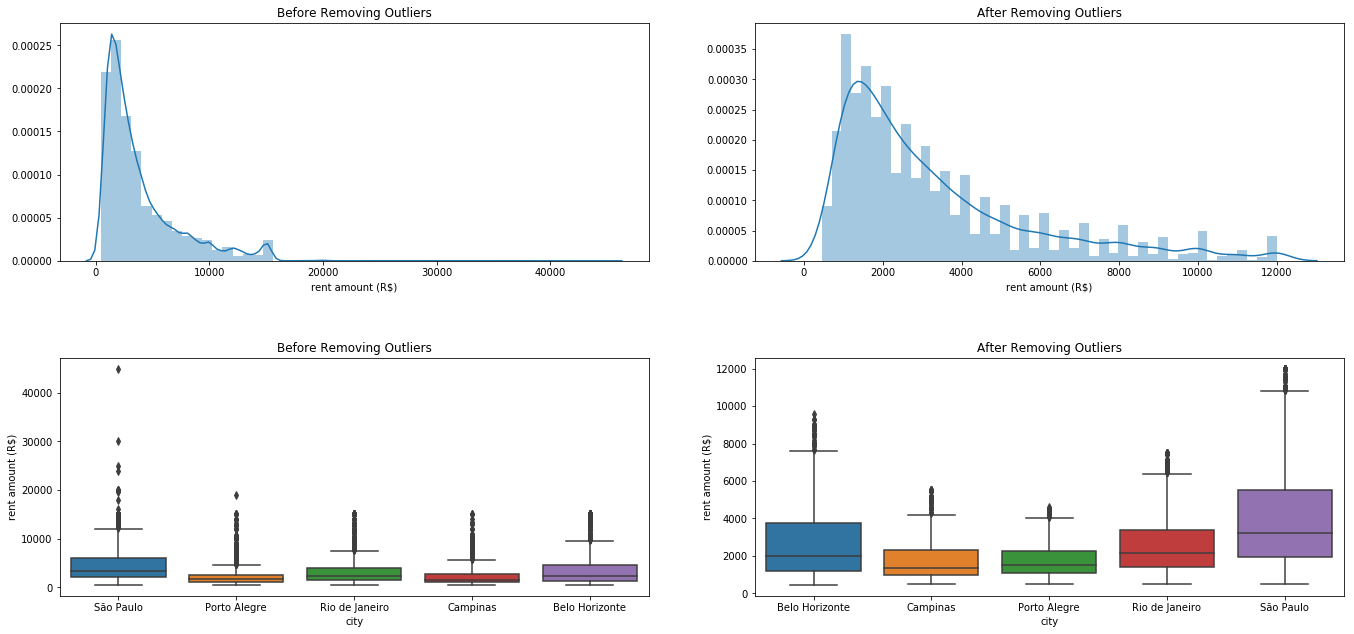

In [13]:
# Lets take a look on how our data was distributed before and after treat outliers

plt.figure(1, figsize=(20, 10))
plt.subplot(2, 2, 1)
sns.distplot(df['rent amount (R$)'])
plt.title('Before Removing Outliers')
plt.subplot(2, 2, 2)
sns.distplot(data['rent amount (R$)'])
plt.title('After Removing Outliers')
plt.subplot(2, 2, 3)
plt.figure(1, figsize=(20, 12))
sns.boxplot(df['city'], df['rent amount (R$)']).set_title('Before Removing Outliers')
plt.subplot(2, 2, 4)
sns.boxplot(data['city'], data['rent amount (R$)']).set_title('After Removing Outliers')
plt.tight_layout(pad=5.0)
plt.show()

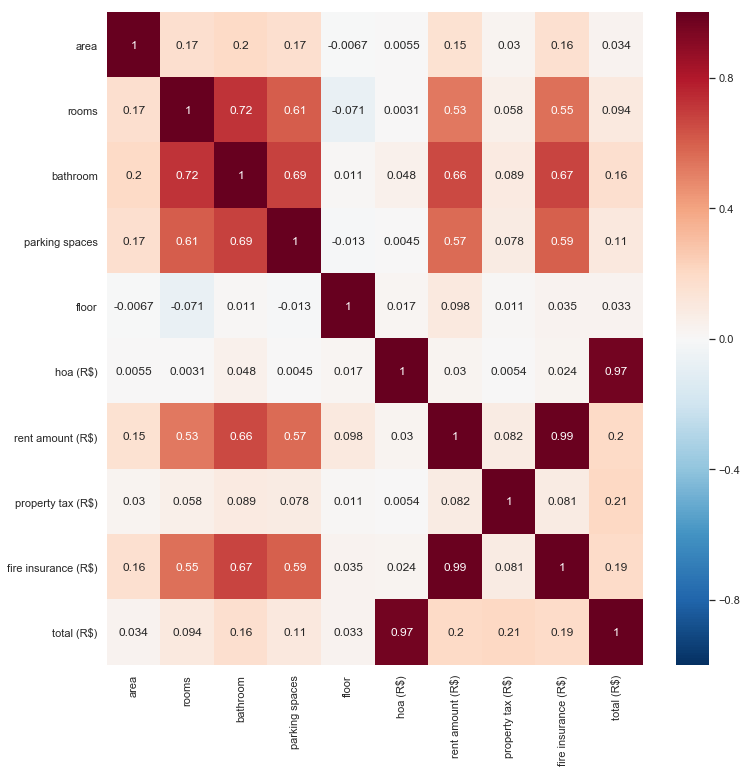

In [16]:
# now let's see the correlation between features
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(), annot=True, cmap='RdBu_r', linecolor='black',vmin=-1, vmax=1)

## Lets split and transform our data into train and test

In [17]:
cols = ['city', 'rooms', 'bathroom', 'parking spaces', 'fire insurance (R$)',
        'furniture']
x = data[cols]
y = data['rent amount (R$)']

**We used the columns that have more correlation with the variable that we want to predict**

In [18]:
labelencoder = LabelEncoder()
x.loc[:, 'furniture'] = labelencoder.fit_transform(x.loc[:, 'furniture'])

C:\Users\Nivethini\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


**We used labelencoder for furniture because only have two values**

In [19]:
dummy = pd.get_dummies(x, columns=['city'])
dummy.drop(columns = ['city_Belo Horizonte'], inplace=True)
x = dummy

**For the citys we use OneHotEncoder and drop the first column to avoid the dummy variable trap**

In [20]:
# Now we split into train and test
x_train, x_test, y_train, y_test = train_test_split(x,
                                                   y,
                                                   test_size = 0.3,
                                                   random_state = 0)

# Model Predictions

In [21]:
# we create a list to storage all the results for later visualization
acc = []
# parameters are the alpha's that we will use to perform the GridSearch
parameters1= [{'alpha': [0.0001, 0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000]}]
# on the regressors we define the models that we want use
regressors = {'Linear Regression': LinearRegression(),
              'Ridge Model': Ridge(alpha=0.1),
              'Decision Tree': DecisionTreeRegressor(),
              'Random Forest': RandomForestRegressor(random_state=1),
              'SVR': SVR(),
              'KNN': KNeighborsRegressor(),
              'Lasso': Lasso(),
              'GridSearchRidge': GridSearchCV(Ridge(), parameters1, cv=4),
              'GridSearchLasso': GridSearchCV(Lasso(), parameters1, cv=4)
             }

In [25]:
# now we perform a loop with each regressor to perform the model, predict the rent 
# and extract the metrics
for i in regressors:
    model = regressors.get(i)
    # here we create a condition because for grid we want to perform the model with the best estimator
    if i == 'GridSearchRidge' or i == 'GridSearchLasso':
        model.fit(x_train, y_train).best_estimator_ 
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    print(i)
    print('MAE:', mean_absolute_error(y_test, prediction))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, prediction)))
    print('R2:', r2_score(y_test, prediction))
    print('*' * 40)
    acc.append([i, mean_absolute_error(y_test, prediction), np.sqrt(mean_squared_error(y_test, prediction)), r2_score(y_test, prediction)])

Linear Regression
MAE: 248.99289449586416
RMSE: 372.6152499362306
R2: 0.978435563565699
****************************************
Ridge Model
MAE: 248.98912238422588
RMSE: 372.61549419180517
R2: 0.9784355352939869
****************************************
Decision Tree
MAE: 141.2116552152166
RMSE: 346.8138229906298
R2: 0.9813185896505354
****************************************
Random Forest
MAE: 141.08075583369595
RMSE: 295.98079124251603
R2: 0.9863935786362991
****************************************


C:\Users\Nivethini\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR
MAE: 1551.9569900522486
RMSE: 2569.299940825056
R2: -0.025289420627535364
****************************************
KNN
MAE: 160.46795856999665
RMSE: 315.0206757145174
R2: 0.9845867231272063
****************************************
Lasso
MAE: 247.54779770272793
RMSE: 372.82011833939237
R2: 0.9784118442672647
****************************************
GridSearchRidge
MAE: 248.95527069031468
RMSE: 372.6177481766283
R2: 0.9784352744024033
****************************************
GridSearchLasso
MAE: 248.99274499244535
RMSE: 372.6152612820053
R2: 0.9784355622524664
****************************************


C:\Users\Nivethini\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Nivethini\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Nivethini\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

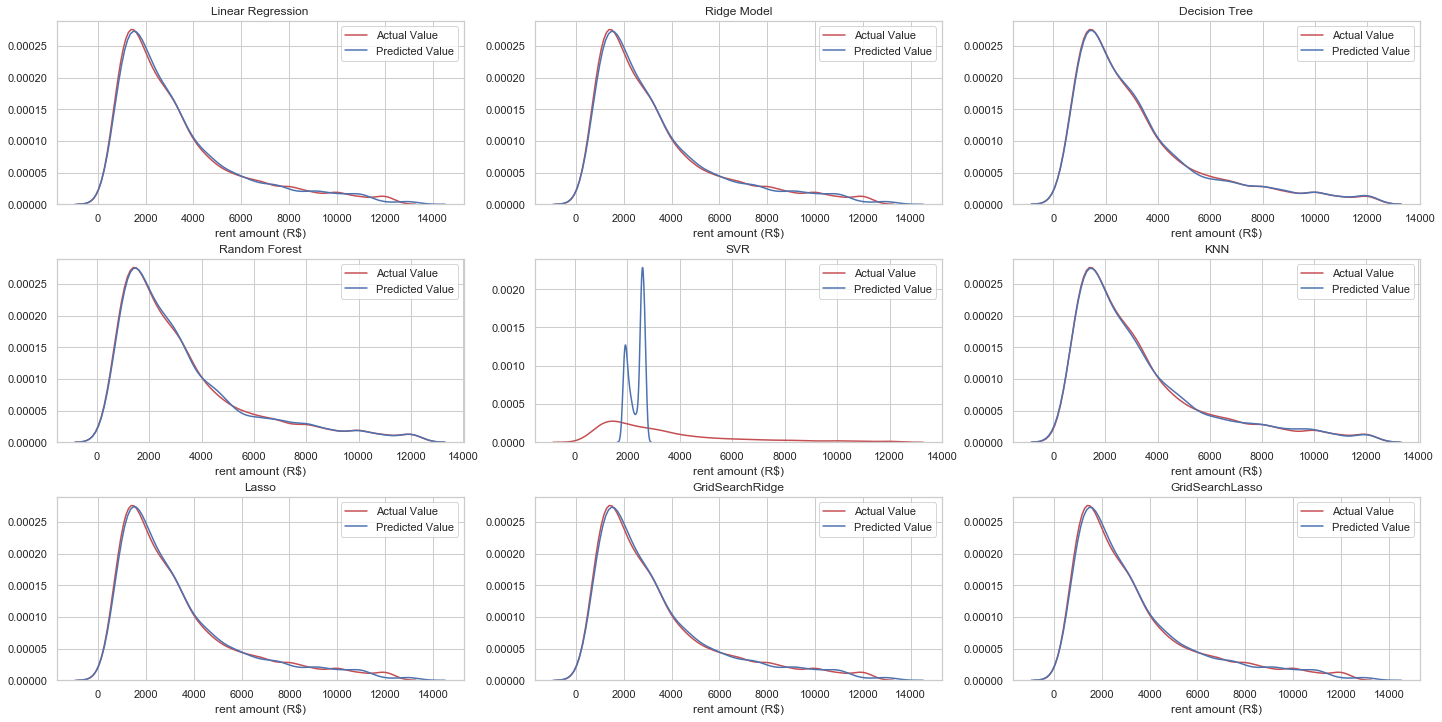

In [26]:
# now let's follow the same loop and visualize the plot's for each regressor
j = 1
plt.figure(figsize=(20,10))
for i in regressors:
    model = regressors.get(i)
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    plt.subplot(3, 3, j)
    plt.title(i)
    ax1 = sns.distplot(y_test,hist=False,kde =True,color ="r",label ="Actual Value")
    sns.distplot(prediction ,color ="b",hist = False,kde =True, label = "Predicted Value",ax =ax1).set_title(i)
    j+=1
plt.tight_layout(pad = 0.5)

**Since our accuracy is very high, the curves are overlapted**

## Analysis of the results

In [27]:
# lets sort our list of results and transform into a dataframe
acc.sort(key = lambda y:y[3], reverse=True)
acc = pd.DataFrame(data = acc, columns=['model', 'MAE', 'RMSE', 'R2'])

In [28]:
# now let's visualize it
acc.head(len(regressors))

,model,MAE,RMSE,R2
0,Random Forest,141.080756,295.980791,0.986394
1,Random Forest,141.080756,295.980791,0.986394
2,Random Forest,141.080756,295.980791,0.986394
3,Random Forest,141.080756,295.980791,0.986394
4,KNN,160.467959,315.020676,0.984587
5,KNN,160.467959,315.020676,0.984587
6,KNN,160.467959,315.020676,0.984587
7,KNN,160.467959,315.020676,0.984587
8,Decision Tree,140.383545,344.691739,0.981547


**RandomForest it's our best perfomer in all three metrics**